# Zonal Statistics - continuous values

In [1]:
import glob, os
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterstats
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
from IPython.display import display
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline
plotly.offline.init_notebook_mode()

print('All libraries successfully imported!')
print(f'Rasterstats : {rasterstats.__version__}')

All libraries successfully imported!
Rasterstats : 0.14.0


In [2]:
import warnings
warnings.filterwarnings("ignore")

print("BE CAREFULL warning are masked !!")

BE CAREFULL warning are masked !!


## Set parameters

Choose statistics :
- min
- max
- mean

In [3]:
index_name = 'NDVI'

stat_name = 'mean'

nodata_val = -10000

### Date
The date must be in each image filename. `begin_date` is the first position of the date

E.g. : "SITE_3_**2**0181108_NDVI.tif" --> **begin_date = 8**

In [4]:
format     = '%Y%m%d' # format : YYYYMMDD
begin_date = 8

## Set directory

In [5]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'


# Rasters files directory
raster_file_list = sorted(glob.glob(f'{work_path}{index_name}/*{index_name}.tif'))

print('Raster files timeseries :')
for raster_file in raster_file_list:
    print(raster_file)

# Vector file
vector_file  = f'{work_path}IN_SITU/NAMUR_2020_IN_SITU_ROI.shp'

# Zonal statistics output
zonal_stat_path = f'{work_path}ZONAL_STATS/'
zonal_stat_csv  = f'{zonal_stat_path}zonal_stat_cont_{index_name}.csv'
zonal_stat_shp  = f'{zonal_stat_path}zonal_stat_cont_{index_name}.shp'

Path(zonal_stat_path).mkdir(parents=True, exist_ok=True)

Raster files timeseries :
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200116T105309_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200212T104049_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200316T104709_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200417T104021_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200520T105031_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200621T103629_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200719T105031_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200813T104629_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200914T104031_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20201019T103959_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20201118T104329_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_202

## Check if raster and vector are projected to the same CRS

In [6]:
gdf = gpd.read_file(vector_file)
src = rasterio.open(raster_file_list[0], "r")

crs_vector = str(gdf.crs).split(":",1)[1]
crs_raster = str(src.crs).split(":",1)[1]

if crs_vector == crs_raster:
    print(f'CRS are the same : EPSG:{crs_vector} = EPSG:{crs_raster}')
else:
    print('We must reproject vector file')

    gdf = gdf.to_crs(epsg=crs_raster)

CRS are the same : EPSG:32631 = EPSG:32631


**Check if raster and vector file are intersecting**

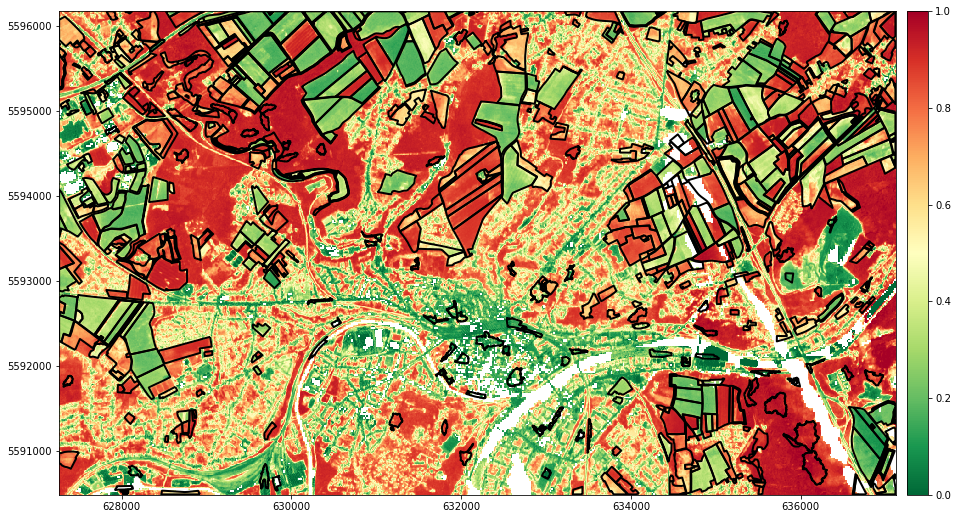

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

# Plot vector
gdf.plot(facecolor='none', edgecolor='black', linewidth = 2, ax=ax)

# Plot image
color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()

src = rasterio.open(raster_file_list[6], "r")
im_rio = rasterio.plot.show(src, cmap=reversed_color_map, vmin=0, vmax=1, ax=ax)
im_rio = im_rio.get_images()[0]

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)


plt.box(False)

## Get date of each image

In [8]:
dict_list = []

for im in raster_file_list:
            
        date_str = os.path.basename(im)[begin_date-1:begin_date-1+8]

        date_im = datetime.datetime.strptime(date_str, format).date()

        dict_list.append({'date': date_im,
                            'im_path': im})

im_date_path_df = pd.DataFrame.from_dict(dict_list).sort_values('date')

display(im_date_path_df)

date                                            im_path
0   2020-01-16  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
1   2020-02-12  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
2   2020-03-16  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
3   2020-04-17  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
4   2020-05-20  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
5   2020-06-21  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
6   2020-07-19  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
7   2020-08-13  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
8   2020-09-14  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
9   2020-10-19  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
10  2020-11-18  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
11  2020-12-18  /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...

## Compute zonal statistics

In [9]:
def mean_div_std(x):

    mean = np.mean(x)
    std  = np.std(x)

    result = mean / std

    return result

In [10]:
df_list = []
date_list = []

for i, row in im_date_path_df.iterrows():
    im         = row['im_path']
    long_date  = row['date']

    day   = str(long_date)[8:10]
    month = str(long_date)[5:7]
    year  = str(long_date)[0:4]
    
    print(long_date)

    date_list.append(long_date)

    date = day + month + year  # Year at the end because it will be truncated when saved to ESRI Shapefile

    # Open GeoTIFF file
    src = rasterio.open(im, 'r')
    im_arr = src.read(1)
    
    # Change NaN by "nodata_val"
    im_arr = np.nan_to_num(im_arr, nan=nodata_val)

    # Get transform from profile (metadata)
    profile = src.profile
    transform = profile['transform']
    
    src.close()

    df = pd.DataFrame(zonal_stats(gdf,
                                  im_arr,
                                  affine=transform,
                                  stats=['count','nodata','mean','std'],
                                  nodata=-10000,
                                  add_stats={'mean_div_std':mean_div_std}
                                  ))
    
    df = df.rename(columns={'count': f'valid_{date}','nodata': f'nan___{date}','mean': f'mean__{date}','std': f'std___{date}', 'mean_div_std':f'mDIVs_{date}'})

    df[f'nan___{date}'] = df[f'nan___{date}'].fillna(0)
    df = df.astype({f'nan___{date}': int, f'mDIVs_{date}': float})
    
    df_list.append(df)
    

dfs = pd.concat(df_list, axis=1).round(4)

display(dfs)


2020-01-16
2020-02-12
2020-03-16
2020-04-17
2020-05-20
2020-06-21
2020-07-19
2020-08-13
2020-09-14
2020-10-19
2020-11-18
2020-12-18


mean__16012020  valid_16012020  std___16012020  nan___16012020  \
0            0.7395              25          0.0834               0   
1            0.7475              26          0.0380               0   
2            0.7392              26          0.1276               1   
3            0.6598              70          0.0600              18   
4            0.7268             208          0.0634               0   
..              ...             ...             ...             ...   
728             NaN               0             NaN              56   
729          0.5909              65          0.0865              71   
730          0.6248              45          0.0683              59   
731          0.2090              52          0.0713               0   
732          0.1907              75          0.0376               1   

     mDIVs_16012020  mean__12022020  valid_12022020  std___12022020  \
0            8.8643          0.1272               3          0.1198   
1           19.6801             NaN               0             NaN   
2            5.7916             NaN               0             NaN   
3           11.0008          0.6801              19          0.0407   
4           11.4695             NaN               0             NaN   
..              ...             ...             ...             ...   
728             NaN          0.3371              33          0.0269   
729          6.8274          0.1317               4          0.0358   
730          9.1492          0.2534              43          0.0603   
731          2.9304          0.1992              40          0.0735   
732          5.0693          0.2057              71          0.0631   

     nan___12022020  mDIVs_12022020  ...  mean__18112020  valid_18112020  \
0                22          1.0619  ...          0.7976              25   
1                26             NaN  ...          0.7914              26   
2                27             NaN  ...          0.6331              27   
3                69         16.6937  ...          0.6573              88   
4               208             NaN  ...          0.8323             206   
..              ...             ...  ...             ...             ...   
728              23         12.5295  ...          0.6595              15   
729             132          3.6768  ...          0.6570             118   
730              61          4.1994  ...          0.6661              96   
731              12          2.7110  ...          0.2529              52   
732               5          3.2603  ...          0.2429              76   

     std___18112020  nan___18112020  mDIVs_18112020  mean__18122020  \
0            0.0516               0         15.4615          0.7610   
1            0.0376               0         21.0200          0.7185   
2            0.1587               0          3.9892          0.6759   
3            0.0958               0          6.8626          0.6309   
4            0.0724               2         11.5005          0.8127   
..              ...             ...             ...             ...   
728          0.0514              41         12.8283          0.5909   
729          0.1176              18          5.5887          0.5920   
730          0.0597               8         11.1671          0.6007   
731          0.1161               0          2.1778          0.2505   
732          0.0557               0          4.3587          0.2266   

     valid_18122020  std___18122020  nan___18122020  mDIVs_18122020  
0                25          0.0409               0         18.6177  
1                26          0.0311               0         23.0900  
2                26          0.1439               1          4.6973  
3                62          0.0733              26          8.6033  
4               204          0.0597               4         13.6152  
..              ...             ...             ...             ...  
728               5          0.0741        

## Plot timeseries

In [15]:
df = dfs.filter(regex='mean')

display(df)

df['parcel_id'] = df.index

df = df.set_index('parcel_id')

df = df.transpose()

df['date'] = date_list


df = df.melt(id_vars=['date'], var_name='parcel_id')

df = df.merge(gdf, left_on='parcel_id', right_on='id')

df = df[['date','parcel_id','value','sub_nb','sub','class_nb','class']]

display(df)


mean__16012020  mean__12022020  mean__16032020  mean__17042020  \
0            0.7395          0.1272          0.8413          0.8236   
1            0.7475             NaN          0.7638          0.8128   
2            0.7392             NaN          0.7566          0.5829   
3            0.6598          0.6801          0.6979          0.8038   
4            0.7268             NaN          0.7962          0.8004   
..              ...             ...             ...             ...   
728             NaN          0.3371          0.5573          0.6364   
729          0.5909          0.1317          0.4802          0.6402   
730          0.6248          0.2534          0.5915             NaN   
731          0.2090          0.1992          0.1808          0.1673   
732          0.1907          0.2057          0.1596             NaN   

     mean__20052020  mean__21062020  mean__19072020  mean__13082020  \
0            0.6891          0.7709          0.7815          0.4859   
1            0.7638          0.5150          0.7029          0.3949   
2            0.5943          0.7457          0.7798          0.5395   
3            0.8918          0.7204          0.6554          0.6826   
4            0.5363          0.7735          0.8932          0.6061   
..              ...             ...             ...             ...   
728          0.9057          0.6302          0.9453          0.8781   
729          0.7913          0.5485          0.8005          0.7715   
730          0.8734          0.9049          0.9240          0.8966   
731          0.1392          0.1767          0.1832          0.2076   
732          0.1336          0.1465          0.1570          0.1960   

     mean__14092020  mean__19102020  mean__18112020  mean__18122020  
0            0.5481          0.6841          0.7976          0.7610  
1            0.6004          0.6972          0.7914          0.7185  
2            0.4648          0.5568          0.6331          0.6759  
3            0.7663          0.8264          0.6573          0.6309  
4            0.5772          0.5625          0.8323          0.8127  
..              ...             ...             ...             ...  
728          0.8661          0.8224          0.6595          0.5909  
729          0.8120          0.7472          0.6570          0.5920  
730          0.8531          0.8123          0.6661          0.6007  
731          0.1431          0.2825          0.2529          0.2505  
732          0.1671          0.2447          0.2429          0.2266  

[733 rows x 12 columns]

date parcel_id   value  sub_nb                    sub  class_nb  \
0     2020-01-16         0  0.7395    3199  Grassland and meadows       319   
1     2020-02-12         0  0.1272    3199  Grassland and meadows       319   
2     2020-03-16         0  0.8413    3199  Grassland and meadows       319   
3     2020-04-17         0  0.8236    3199  Grassland and meadows       319   
4     2020-05-20         0  0.6891    3199  Grassland and meadows       319   
...          ...       ...     ...     ...                    ...       ...   
8791  2020-08-13       732  0.1960    7211             Bare soils       721   
8792  2020-09-14       732  0.1671    7211             Bare soils       721   
8793  2020-10-19       732  0.2447    7211             Bare soils       721   
8794  2020-11-18       732  0.2429    7211             Bare soils       721   
8795  2020-12-18       732  0.2266    7211             Bare soils       721   

                      class  
0     Grassland and meadows  
1     Grassland and meadows  
2     Grassland and meadows  
3     Grassland and meadows  
4     Grassland and meadows  
...                     ...  
8791             Bare soils  
8792             Bare soils  
8793             Bare soils  
8794             Bare soils  
8795             Bare soils  

[8796 rows x 7 columns]

In [12]:
fig = px.line(df,
              x='date',
              y='value',
              color='class_nb',
              line_group='parcel_id',
              hover_data=['sub_nb','sub'],
              title= 'title')

fig.show()

## Write output to shapefile

In [13]:
gdf_with_zonal_stat = pd.concat([gdf, dfs], axis=1, join="inner")

display(gdf_with_zonal_stat)

#gdf_with_zonal_stat.columns = gdf_with_zonal_stat.columns.astype(str)


gdf_with_zonal_stat.to_file(zonal_stat_shp)

print(f'SHP file was created : {zonal_stat_shp}')

id  lc_nb                     lc  grp_nb                    grp  \
0      0      3  Grassland and meadows      31  Grassland and meadows   
1      1      3  Grassland and meadows      31  Grassland and meadows   
2      2      3  Grassland and meadows      31  Grassland and meadows   
3      3      3  Grassland and meadows      31  Grassland and meadows   
4      4      3  Grassland and meadows      31  Grassland and meadows   
..   ...    ...                    ...     ...                    ...   
728  727      6                 Forest      69                 Forest   
729  730      6                 Forest      69                 Forest   
730  731      6                 Forest      69                 Forest   
731  711      7              Bare soil      72             Bare soils   
732  732      7              Bare soil      72             Bare soils   

     class_nb                  class  sub_nb                    sub  grp_1_nb  \
0         319  Grassland and meadows    3199  Grassland and meadows         3   
1         319  Grassland and meadows    3199  Grassland and meadows         3   
2         319  Grassland and meadows    3199  Grassland and meadows         3   
3         319  Grassland and meadows    3199  Grassland and meadows         3   
4         319  Grassland and meadows    3199  Grassland and meadows         3   
..        ...                    ...     ...                    ...       ...   
728       699                 Forest    6999                 Forest        69   
729       699                 Forest    6999                 Forest        69   
730       699                 Forest    6999                 Forest        69   
731       721             Bare soils    7211             Bare soils        72   
732       721             Bare soils    7211             Bare soils        72   

     ... mean__18112020  valid_18112020 std___18112020 nan___18112020  \
0    ...         0.7976              25         0.0516              0   
1    ...         0.7914              26         0.0376              0   
2    ...         0.6331              27         0.1587              0   
3    ...         0.6573              88         0.0958              0   
4    ...         0.8323             206         0.0724              2   
..   ...            ...             ...            ...            ...   
728  ...         0.6595              15         0.0514             41   
729  ...         0.6570             118         0.1176             18   
730  ...         0.6661              96         0.0597              8   
731  ...         0.2529              52         0.1161              0   
732  ...         0.2429              76         0.0557              0   

     mDIVs_18112020  mean__18122020  valid_18122020  std___18122020  \
0           15.4615          0.7610              25          0.0409   
1           21.0200          0.7185              26          0.0311   
2            3.9892          0.6759              26          0.1439   
3            6.8626          0.6309              62          0.0733   
4           11.5005          0.8127             204          0.0597   
..              ...             ...             ...             ...   
728         12.8283          0.5909               5          0.0741   
729          5.5887          0.5920              68          0.0652   
730         11.1671          0.6007              70          0.0541   
731          2.1778          0.2505              52          0.0940   
732          4.3587          0.2266              73          0.0577   

     nan___18122020  mDIVs_18122020  
0                 0         18.6177  
1                 0         23.0900  
2                 1          4.6973  
3                26          8.6033  
4                 4         13.6152  
..              ...             ...  
728              51          7.9720  
729              68          9.0778  
730              34         11.1064  
731               0          2.6662  
732     

SHP file was created : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/ZONAL_STATS/zonal_stat_cont_NDVI.shp


## Write output to CSV

In [14]:
gdf_with_zonal_stat = pd.concat([gdf, dfs], axis=1, join="inner")

gdf_with_zonal_stat = gdf_with_zonal_stat.drop(columns='geometry')

display(gdf_with_zonal_stat)

gdf_with_zonal_stat.to_csv(zonal_stat_csv)

print(f'CSV file was created : {zonal_stat_csv}')

id  lc_nb                     lc  grp_nb                    grp  \
0      0      3  Grassland and meadows      31  Grassland and meadows   
1      1      3  Grassland and meadows      31  Grassland and meadows   
2      2      3  Grassland and meadows      31  Grassland and meadows   
3      3      3  Grassland and meadows      31  Grassland and meadows   
4      4      3  Grassland and meadows      31  Grassland and meadows   
..   ...    ...                    ...     ...                    ...   
728  727      6                 Forest      69                 Forest   
729  730      6                 Forest      69                 Forest   
730  731      6                 Forest      69                 Forest   
731  711      7              Bare soil      72             Bare soils   
732  732      7              Bare soil      72             Bare soils   

     class_nb                  class  sub_nb                    sub  grp_1_nb  \
0         319  Grassland and meadows    3199  Grassland and meadows         3   
1         319  Grassland and meadows    3199  Grassland and meadows         3   
2         319  Grassland and meadows    3199  Grassland and meadows         3   
3         319  Grassland and meadows    3199  Grassland and meadows         3   
4         319  Grassland and meadows    3199  Grassland and meadows         3   
..        ...                    ...     ...                    ...       ...   
728       699                 Forest    6999                 Forest        69   
729       699                 Forest    6999                 Forest        69   
730       699                 Forest    6999                 Forest        69   
731       721             Bare soils    7211             Bare soils        72   
732       721             Bare soils    7211             Bare soils        72   

     ... mean__18112020  valid_18112020 std___18112020  nan___18112020  \
0    ...         0.7976              25         0.0516               0   
1    ...         0.7914              26         0.0376               0   
2    ...         0.6331              27         0.1587               0   
3    ...         0.6573              88         0.0958               0   
4    ...         0.8323             206         0.0724               2   
..   ...            ...             ...            ...             ...   
728  ...         0.6595              15         0.0514              41   
729  ...         0.6570             118         0.1176              18   
730  ...         0.6661              96         0.0597               8   
731  ...         0.2529              52         0.1161               0   
732  ...         0.2429              76         0.0557               0   

     mDIVs_18112020  mean__18122020  valid_18122020  std___18122020  \
0           15.4615          0.7610              25          0.0409   
1           21.0200          0.7185              26          0.0311   
2            3.9892          0.6759              26          0.1439   
3            6.8626          0.6309              62          0.0733   
4           11.5005          0.8127             204          0.0597   
..              ...             ...             ...             ...   
728         12.8283          0.5909               5          0.0741   
729          5.5887          0.5920              68          0.0652   
730         11.1671          0.6007              70          0.0541   
731          2.1778          0.2505              52          0.0940   
732          4.3587          0.2266              73          0.0577   

     nan___18122020  mDIVs_18122020  
0                 0         18.6177  
1                 0         23.0900  
2                 1          4.6973  
3                26          8.6033  
4                 4         13.6152  
..              ...             ...  
728              51          7.9720  
729              68          9.0778  
730              34         11.1064  
731               0          2.666

CSV file was created : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/ZONAL_STATS/zonal_stat_cont_NDVI.csv
